In [2]:
import matplotlib.pyplot as plt
import numpy as np

**全部实验使用 MNIST 数据集**

In [3]:
from torchvision.datasets import mnist # 导入 pytorch 内置的 mnist 数据
train_set = mnist.MNIST('./data', train=True,  download=True) # 重新载入数据集，申明定义的数据变换
test_set = mnist.MNIST('./data', train=False,  download=True)

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



102.8%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



112.7%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw




D:\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
print(train_set[0])
print(train_set[0][0])
print(type(train_set[0][0]))
train_set[0][0]

(<PIL.Image.Image image mode=L size=28x28 at 0x271174BC390>, 5)
<PIL.Image.Image image mode=L size=28x28 at 0x271174BC208>
<class 'PIL.Image.Image'>


可见数据是28✖28的灰度图片

**CNN**

In [5]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

1、卷积
首先需要输入是一个 `torch.autograd.Variable()` 的类型，大小是 (batch, channel, H, W)，其中 batch 表示输入的一批数据的数目，第二个是输入的通道数，一般一张彩色的图片是 3，灰度图是 1，而卷积网络过程中的通道数比较大，会出现几十到几百的通道数，H 和 W 表示输入图片的高度和宽度，比如一个 batch 是 32 张图片，每张图片是 3 通道，高和宽分别是 50 和 100，那么输入的大小就是 (32, 3, 50, 100)

经典的Mnist数据集为(28,28)的图片集

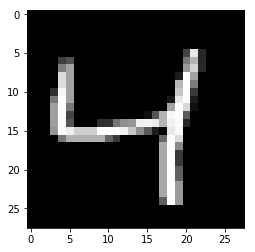

In [6]:
im=train_set[2][0]
plt.imshow(im, cmap='gray')

显然这是4

将图片矩阵转化为 pytorch tensor，并适配卷积输入的要求

In [7]:
im=np.array(im)
im = torch.from_numpy(im.reshape((1, 1, im.shape[0],im.shape[1])))
im.shape

torch.Size([1, 1, 28, 28])

In [8]:
# 使用 nn.Conv2d
conv1 = nn.Conv2d(1, 1, 3, bias=False) # 定义3*3的卷积模板

sobel_kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype='float32') # 定义轮廓检测sobel算子
sobel_kernel = sobel_kernel.reshape((1, 1, 3, 3)) # 适配卷积的输入输出
conv1.weight.data = torch.from_numpy(sobel_kernel) # 给卷积的 kernel 赋值

edge1 = conv1(im.float())# 作用在图片上
edge1 = edge1.data.squeeze().numpy() # 将输出转换为图片的格式

从卷积后图片变小的情况来看，卷积采用的是丢弃法

In [9]:
edge1.shape

(26, 26)

可见边缘检测之后的结果

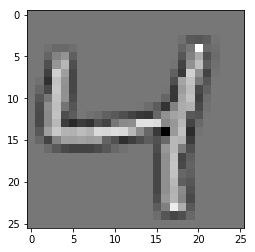

In [10]:
plt.imshow(edge1, cmap='gray')

In [11]:
im.shape

torch.Size([1, 1, 28, 28])

In [12]:
im=im.float()

2、池化层

卷积网络中另外一个非常重要的结构就是池化，这是利用了图片的下采样不变性，即一张图片变小了还是能够看出了这张图片的内容，而使用池化层能够将图片大小降低，非常好地提高了计算效率，同时池化层也没有参数。池化的方式有很多种，比如最大值池化，均值池化等等，在卷积网络中一般使用最大值池化。

In [13]:
# 使用 nn.MaxPool2d
pool1 = nn.MaxPool2d(2, 2)
small_im1 = pool1(im)
small_im1 = small_im1.data.squeeze().numpy()

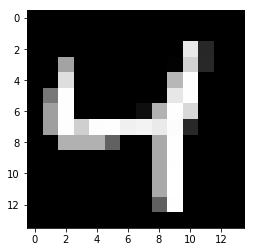

In [14]:
plt.imshow(small_im1, cmap='gray')

可以看到图片几乎没有变化，说明池化层只是减小了图片的尺寸，并不会影响图片的内容

****

> 

**在我们正式进入模型的构建和训练之前，对数据增加一些预处理，同时使用批标准化能够得到非常好的收敛结果，这也是卷积网络能够训练到非常深的层的一个重要原因。** 

在 2015 年一篇论文提出了这个方法，批标准化，简而言之，就是对于每一层网络的输出，对其做一个归一化，使其服从标准的正态分布，这样后一层网络的输入也是一个标准的正态分布，所以能够比较好的进行训练，加快收敛速度

3、批标准化
batch normalization 的实现非常简单，对于给定的一个 batch 的数据 $B = \{x_1, x_2, \cdots, x_m\}$算法的公式如下
​
$$
\mu_B = \frac{1}{m} \sum_{i=1}^m x_i
$$
$$
\sigma^2_B = \frac{1}{m} \sum_{i=1}^m (x_i - \mu_B)^2
$$
$$
\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma^2_B + \epsilon}}
$$
$$
y_i = \gamma \hat{x}_i + \beta
$$
第一行和第二行是计算出一个 batch 中数据的均值和方差，接着使用第三个公式对 batch 中的每个数据点做标准化，$\epsilon$ 是为了计算稳定引入的一个小的常数，通常取 $10^{-5}$，最后利用权重修正得到最后的输出结果

In [15]:
# 批标准化方法
def batch_norm_1d(x, gamma, beta, is_training, moving_mean, moving_var, moving_momentum=0.1):
    eps = 1e-5
    x_mean = torch.mean(x, dim=0, keepdim=True) # 保留维度进行 broadcast
    x_var = torch.mean((x - x_mean) ** 2, dim=0, keepdim=True)
    
#     如果是训练集，则使用计算得出的均值和方差代入式子
    if is_training:
        x_hat = (x - x_mean) / torch.sqrt(x_var + eps)
        
#       算出移动平均均值和方差，与上一层输入的移动均值和方差和这层算出来的均值和方差有关
        moving_mean[:] = moving_momentum * moving_mean + (1. - moving_momentum) * x_mean
        moving_var[:] = moving_momentum * moving_var + (1. - moving_momentum) * x_var
# 测试集直接使用之前训练集处理时算出来的均值和方差
    else:
        x_hat = (x - moving_mean) / torch.sqrt(moving_var + eps)
    return gamma.view_as(x_mean) * x_hat + beta.view_as(x_mean)

这里的 $\gamma$ 和 $\beta$ 都作为参数进行训练

测试的时候不能用测试的数据集去算均值和方差，而是用训练的时候算出的移动平均均值和方差去代替

**** 

4、对数据进行一些必要的预处理

In [16]:
x = np.array(train_set[0][0], dtype='float32') / 255
x = (x - 0.5) / 0.5 # 数据预处理，标准化
x = x.reshape((-1,)) # 拉平
x = torch.from_numpy(x)
x.shape

torch.Size([784])

一列列数据进行处理比较麻烦，可以做个函数进行处理，这里使用mnist.MNIST自带的方法

In [17]:
def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 数据预处理，标准化
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x
train_set = mnist.MNIST('./data', train=True, transform=data_tf, download=True) # 重新载入数据集，申明定义的数据变换
test_set = mnist.MNIST('./data', train=False, transform=data_tf, download=True)

**当数据量很大时，内存往往不足，使用Dataloader迭代处理数据**
DataLoader本质上就是一个iterable（跟python的内置类型list等一样），并利用多进程来加速batch data的处理，使用yield来使用有限的内存

In [18]:
from torch.utils.data import DataLoader
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
test_data = DataLoader(test_set, batch_size=128, shuffle=False)

安排好数据加载处理环节后，开始设计训练环节

In [19]:
class multi_network(nn.Module):
    def __init__(self):
        super(multi_network, self).__init__()
#         网络设计
# 
#       全连接层  类似于100个线性回归模型
        self.layer1 = nn.Linear(784, 100)
    
#  激活函数

# ======================================================================
# 模仿大脑神经元结构，输入的数据经过计算得到结果，接着经过激活函数（兴奋或抑制），再传给下一层神经元 
# 常用的激活函数有sigmoid、tanh、ReLU，其中最普遍最多使用的是ReLU，这里也选择使用ReLU
# ======================================================================
        self.relu = nn.ReLU(True)

        self.layer2 = nn.Linear(100, 10)

# 批处理参数随机初始化，训练过程会逐渐变化

# torch.nn.init 内置了一张叫Xavier的参数初始化方法，
# 方法来源于 2010 年的一篇论文 Understanding the difficulty of training deep feedforward neural networks，
# 其通过数学的推到，证明了这种初始化方式可以使得每一层的输出方差是尽可能相等的
        self.gamma = nn.init.xavier_uniform(torch.randn(100).reshape(1,100),gain=1).to(device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        self.beta = nn.init.xavier_uniform(torch.randn(100).reshape(1,100),gain=1).to(device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

#         self.gamma = nn.Parameter(torch.randn(100))
#         self.beta = nn.Parameter(torch.randn(100))

#  移动均值和方差设为0
        self.moving_mean = Variable(torch.zeros(100))
        self.moving_var = Variable(torch.zeros(100))
        
    def forward(self, x, is_train=True):
        x = self.layer1(x)
        x = batch_norm_1d(x, self.gamma, self.beta, is_train, self.moving_mean, self.moving_var)
        x = self.relu(x)
        x = self.layer2(x)
        return x

In [20]:
net = multi_network()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


**loss 函数**

损失函数表示当前输出和理想输出的差距，越小越好，具体的损失函数多种多样

pytorch提供了很多损失函数https://pytorch.org/docs/0.3.0/nn.html#loss-functions

我们选取最常用的交叉熵

**优化算法**

优化算法参考最优化理论一课知识

常见的优化算法有：

GSD

动量法

Adagrad

RMSProp

Adadelta

Adam

In [21]:
# 使用交叉熵 
criterion = nn.CrossEntropyLoss()

# 使用随机梯度下降，学习率 0.1
optimizer = torch.optim.SGD(net.parameters(), 1e-1) 

In [22]:
# 编写训练函数
from datetime import datetime

# 计算准确率
def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().data
    return num_correct / total


def train(net, train_data, valid_data, num_epochs, optimizer, criterion):
    
#     如果可以使用gpu，则使用gpu
    if torch.cuda.is_available():
        net = net.cuda()
#     单轮训练开始时间
    prev_time = datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        net = net.train()
        for im, label in train_data:
            if torch.cuda.is_available():
                im = Variable(im.cuda())  # (bs, 3, h, w)
                label = Variable(label.cuda())  # (bs, h, w)
            else:
                im = Variable(im)
                label = Variable(label)
            # forward
            output = net(im)
            loss = criterion(output, label)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.data
            train_acc += get_acc(output, label)

#         单轮训练结束时间
        cur_time = datetime.now()
        
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        
        if valid_data is not None:
            valid_loss = 0
            valid_acc = 0
            net = net.eval()
            for im, label in valid_data:
                if torch.cuda.is_available():
                    im = Variable(im.cuda(), volatile=True)
                    label = Variable(label.cuda(), volatile=True)
                else:
                    im = Variable(im, volatile=True)
                    label = Variable(label, volatile=True)
                output = net(im)
                loss = criterion(output, label)
                valid_loss += loss.data
                valid_acc += get_acc(output, label)
            epoch_str = (
                "Epoch %d. Train Loss: %f, Train Acc: %f, Valid Loss: %f, Valid Acc: %f, "
                % (epoch, train_loss / len(train_data),
                   train_acc / len(train_data), valid_loss / len(valid_data),
                   valid_acc / len(valid_data)))
        else:
            epoch_str = ("Epoch %d. Train Loss: %f, Train Acc: %f, " %
                         (epoch, train_loss / len(train_data),
                          train_acc / len(train_data)))
        prev_time = cur_time
        print(epoch_str + time_str)


In [23]:
train(net, train_data, test_data, 10, optimizer, criterion)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch 0. Train Loss: 1.111866, Train Acc: 0.799857, Valid Loss: 0.609479, Valid Acc: 0.900712, Time 00:00:06
Epoch 1. Train Loss: 0.541434, Train Acc: 0.893374, Valid Loss: 0.422503, Valid Acc: 0.912480, Time 00:00:07
Epoch 2. Train Loss: 0.425789, Train Acc: 0.904767, Valid Loss: 0.354653, Valid Acc: 0.919403, Time 00:00:08
Epoch 3. Train Loss: 0.372642, Train Acc: 0.911281, Valid Loss: 0.316241, Valid Acc: 0.925040, Time 00:00:08
Epoch 4. Train Loss: 0.340007, Train Acc: 0.917511, Valid Loss: 0.294168, Valid Acc: 0.928204, Time 00:00:08
Epoch 5. Train Loss: 0.318022, Train Acc: 0.920809, Valid Loss: 0.277307, Valid Acc: 0.930182, Time 00:00:09
Epoch 6. Train Loss: 0.301128, Train Acc: 0.924390, Valid Loss: 0.261797, Valid Acc: 0.932852, Time 00:00:09
Epoch 7. Train Loss: 0.286174, Train Acc: 0.928388, Valid Loss: 0.255951, Valid Acc: 0.934039, Time 00:00:09
Epoch 8. Train Loss: 0.273180, Train Acc: 0.931220, Valid Loss: 0.243764, Valid Acc: 0.936214, Time 00:00:09
Epoch 9. Train Loss

In [24]:
# 打出 moving_mean 的前 10 项
print(net.moving_mean[:10])

tensor([ 2.0328,  3.9691,  1.0366, -0.7004, -0.6154,  4.4201,  0.7199,  0.0683,
         5.8753, -0.0582], grad_fn=<SliceBackward>)
